In [1]:
import sys
sys.path.append("/home/mori/Documents/h2o/env/h2o-env/lib/python3.7/site-packages")
sys.path.append("/home/mori/Documents/h2o/code/h2o-3/h2o-py")

# Monotone constraints GBM demo

## Prepare data

In [2]:
import numpy as np
np.random.seed(1)

def f(x):
    """The function to predict."""
    return x * np.sin(x)

def f2(x):
    """The function to predict."""
    return x * np.exp(x)

def f3(x):
    """The function to predict."""
    return x * x

#  First the noiseless case
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)

# Observations
y = f(X).ravel()

dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y = y.astype(np.float32)

# Mesh the input space for evaluations of the real function, the prediction and its MSE
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
xx = xx.astype(np.float32)

In [3]:
import matplotlib.pyplot as plt

# Plot the function, the prediction and the 95% confidence interval
def plot_prediction_quantile(xx, fxx, xx_label, X, y, y_pred,ylim, title, y_upper=None, y_lower=None, 
                             confidence_label=None):
    fig = plt.figure()
    plt.plot(xx, fxx, 'g:', label=xx_label)
    if (X is not None) and (y is not None):
        plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
    plt.plot(xx, y_pred, 'r-', label=u'Prediction')
    if (y_upper is not None) and (y_lower is not None):
        plt.plot(xx, y_upper, 'k-')
        plt.plot(xx, y_lower, 'k-')
        plt.fill(np.concatenate([xx, xx[::-1]]),
                 np.concatenate([y_upper, y_lower[::-1]]),
                 alpha=.5, fc='b', ec='None', label=confidence_label)
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.ylim(ylim)
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()

## H2O-3

In [4]:
import h2o
from h2o.estimators import H2OGradientBoostingEstimator as GBM
h2o.init(strict_version_check=False, port=54321)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,14 mins 32 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,20 days
H2O_cluster_name:,mori
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4.918 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


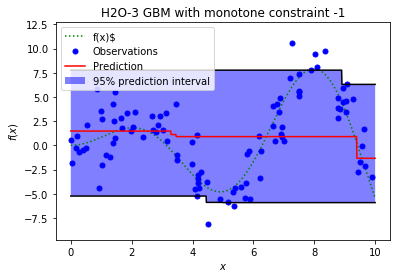

In [5]:
train_X = h2o.H2OFrame({'X': (X.T)[0].tolist(), 'y': y.tolist()},
                            column_types=['numeric', 'numeric'])

train_xx = h2o.H2OFrame({'X': (xx.T)[0].tolist(), 'y': y.tolist()},
                            column_types=['numeric', 'numeric'])

params = {"ntrees" : 100,
          "max_depth" : 5,
          "learn_rate" : 0.1,
          "min_rows" : 3,
          "nbins": 20,
          "nbins_top_level" : 20,
          "monotone_constraints" : {"X": -1}}

model_upper_h2o = GBM(**params,
                      distribution='quantile', 
                      quantile_alpha=0.95)
model_upper_h2o.train(x='X', y='y', training_frame=train_X)
y_upper_h2o = list(model_upper_h2o.predict(train_xx).as_data_frame()['predict'])

model_lower_h2o = GBM(**params,
                      distribution='quantile', 
                      quantile_alpha=0.05)
model_lower_h2o.train(x='X', y='y', training_frame=train_X)
y_lower_h2o = list(model_lower_h2o.predict(train_xx).as_data_frame()['predict'])

model_middle_h2o = GBM(**params,
                       distribution='quantile', 
                       quantile_alpha=0.5)
model_middle_h2o.train(x='X', y='y', training_frame=train_X)
y_middle_h2o = list(model_middle_h2o.predict(train_xx).as_data_frame()['predict'])

model_h2o = GBM(**params,
                distribution='gaussian')

model_h2o.train(x='X', y='y', training_frame=train_X)
y_pred_h2o = list(model_h2o.predict(train_xx).as_data_frame()['predict'])

plot_prediction_quantile(xx, f(xx), r'f(x)$', X, y, y_pred_h2o,[min(y)+0.2*min(y), max(y)+0.2*max(y)], "H2O-3 GBM with monotone constraint -1",
                         y_upper_h2o, y_lower_h2o, '95% prediction interval')

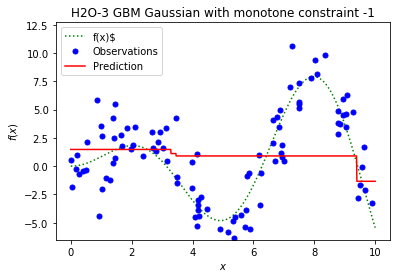

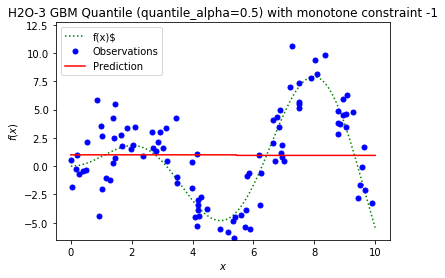

In [6]:
plot_prediction_quantile(xx, f(xx), r'f(x)$', X, y, y_pred_h2o, [min(y)-0.2*min(y), max(y)+0.2*max(y)], "H2O-3 GBM Gaussian with monotone constraint -1")
plot_prediction_quantile(xx, f(xx), r'f(x)$', X, y, y_middle_h2o, [min(y)-0.2*min(y), max(y)+0.2*max(y)], "H2O-3 GBM Quantile (quantile_alpha=0.5) with monotone constraint -1")

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


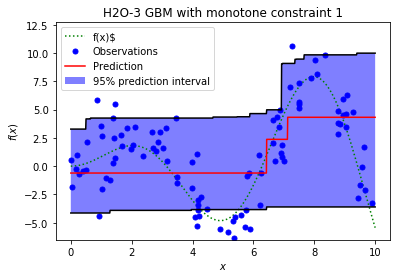

In [7]:
train_X = h2o.H2OFrame({'X': (X.T)[0].tolist(), 'y': y.tolist()},
                            column_types=['numeric', 'numeric'])

train_xx = h2o.H2OFrame({'X': (xx.T)[0].tolist(), 'y': y.tolist()},
                            column_types=['numeric', 'numeric'])

params = {"ntrees" : 100,
          "max_depth" : 5,
          "learn_rate" : 0.1,
          "min_rows" : 5,
          "nbins": 20,
          "nbins_top_level" : 20,
          "monotone_constraints" : {"X": 1}}

model_upper_h2o = GBM(**params,
                      distribution='quantile', 
                      quantile_alpha=0.95)
model_upper_h2o.train(x='X', y='y', training_frame=train_X)
y_upper_h2o = list(model_upper_h2o.predict(train_xx).as_data_frame()['predict'])

model_lower_h2o = GBM(**params,
                      distribution='quantile', 
                      quantile_alpha=0.05)
model_lower_h2o.train(x='X', y='y', training_frame=train_X)
y_lower_h2o = list(model_lower_h2o.predict(train_xx).as_data_frame()['predict'])

model_middle_h2o = GBM(**params,
                       distribution='quantile', 
                       quantile_alpha=0.5)
model_middle_h2o.train(x='X', y='y', training_frame=train_X)
y_middle_h2o = list(model_middle_h2o.predict(train_xx).as_data_frame()['predict'])

model_h2o = GBM(**params,
                distribution='gaussian')

model_h2o.train(x='X', y='y', training_frame=train_X)
y_pred_h2o = list(model_h2o.predict(train_xx).as_data_frame()['predict'])

plot_prediction_quantile(xx, f(xx), r'f(x)$', X, y, y_pred_h2o,[min(y)-0.2*min(y), max(y)+0.2*max(y)], "H2O-3 GBM with monotone constraint 1",
                         y_upper_h2o, y_lower_h2o, '95% prediction interval')

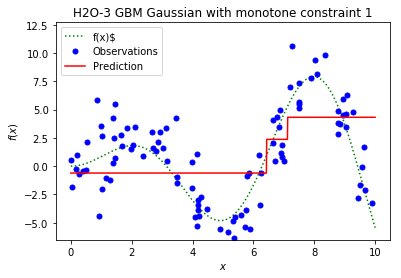

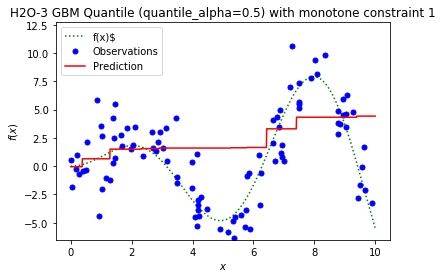

In [8]:
plot_prediction_quantile(xx, f(xx), r'f(x)$', X, y, y_pred_h2o, [min(y)-0.2*min(y), max(y)+0.2*max(y)], "H2O-3 GBM Gaussian with monotone constraint 1")
plot_prediction_quantile(xx, f(xx), r'f(x)$', X, y, y_middle_h2o, [min(y)-0.2*min(y), max(y)+0.2*max(y)], "H2O-3 GBM Quantile (quantile_alpha=0.5) with monotone constraint 1")

In [9]:
model_middle_h2o = GBM(**params,
                       distribution='quantile', 
                       quantile_alpha=0.5)
model_middle_h2o.train(x='X', y='y', training_frame=train_X)
y_middle_h2o = list(model_middle_h2o.predict(train_xx).as_data_frame()['predict'])

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


In [10]:
# Print H2O GBM tree using Graphviz
def plot_trees(model, tree_index=None, dot_path='/home/mori/Documents/h2o/code/test/quantile_constraints/tree.dot'):
    import graphviz
    mojo_path = model.download_mojo()
    mojo_dot = h2o.print_mojo(mojo_path, format='dot')

    with open(dot_path, 'a') as the_file:
        the_file.write(mojo_dot)
        
    return graphviz.Source(mojo_dot)

In [11]:
plot_trees(model_upper_h2o)

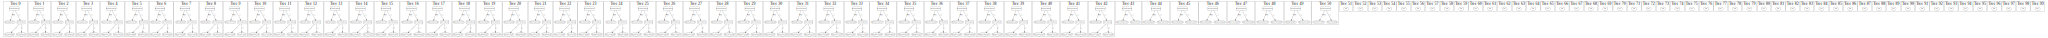

In [12]:
plot_trees(model_h2o)

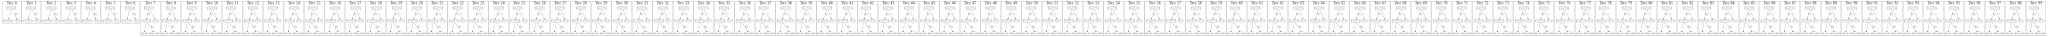

In [13]:
plot_trees(model_lower_h2o)

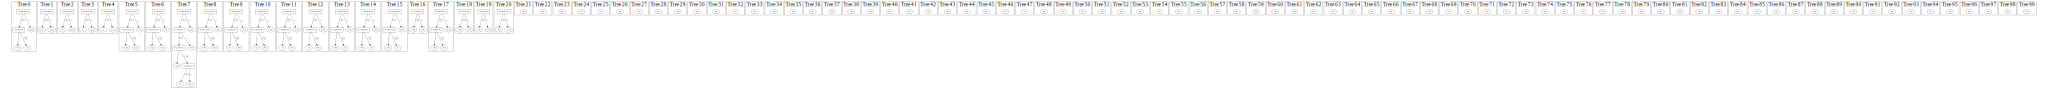

In [14]:
plot_trees(model_middle_h2o)

## LightGBM

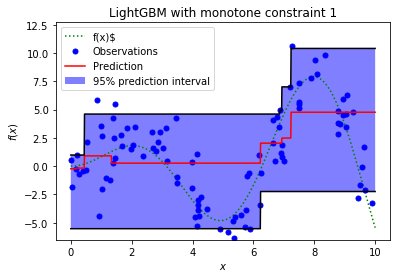

In [15]:
from lightgbm import LGBMRegressor

lgb_params = {
    'n_jobs': 1,
    'max_depth': 5,
    'min_data_in_leaf': 3,
    'n_estimators': 100,
    'learning_rate': 0.1,
    'colsample_bytree': 0.9,
    'boosting_type': 'gbdt',
    'monotone_constraints': 1
}

lgb_lower = LGBMRegressor(objective='quantile', alpha=0.05, **lgb_params)
lgb_lower.fit(X, y)
y_lower_lgb = lgb_lower.predict(xx)

lgb_upper = LGBMRegressor(objective='quantile', alpha=0.95, **lgb_params)
lgb_upper.fit(X, y)
y_upper_lgb = lgb_upper.predict(xx)

lgb_middle = LGBMRegressor(objective='quantile', alpha=0.5, **lgb_params)
lgb_middle.fit(X, y)
y_middle_lgb = lgb_middle.predict(xx)

lgb = LGBMRegressor(objective='regression', **lgb_params)
lgb.fit(X, y)
y_pred_lgb = lgb.predict(xx)

plot_prediction_quantile(xx, f(xx), r'f(x)$', X, y, y_middle_lgb, [min(y)-0.2*min(y), max(y)+0.2*max(y)], "LightGBM with monotone constraint 1",
                         y_upper_lgb, y_lower_lgb, '95% prediction interval')

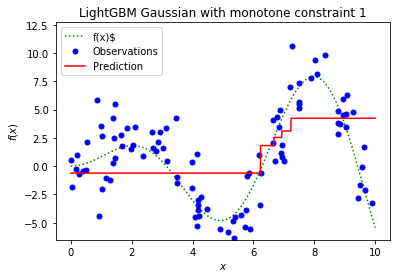

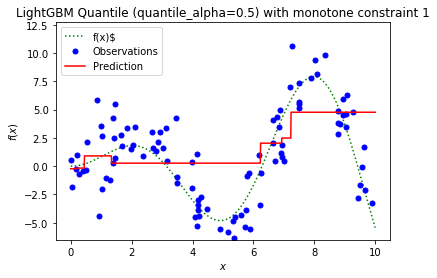

In [16]:
plot_prediction_quantile(xx, f(xx), r'f(x)$', X, y, y_pred_lgb, [min(y)-0.2*min(y), max(y)+0.2*max(y)], "LightGBM Gaussian with monotone constraint 1")
plot_prediction_quantile(xx, f(xx), r'f(x)$', X, y, y_middle_lgb, [min(y)-0.2*min(y), max(y)+0.2*max(y)], "LightGBM Quantile (quantile_alpha=0.5) with monotone constraint 1")

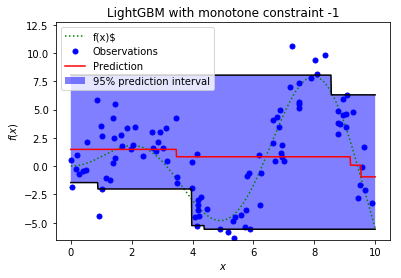

In [17]:
lgb_params = {
    'n_jobs': 1,
    'max_depth': 5,
    'min_data_in_leaf': 3,
    'n_estimators': 100,
    'learning_rate': 0.1,
    'colsample_bytree': 0.9,
    'boosting_type': 'gbdt',
    'monotone_constraints': -1
}

lgb_lower = LGBMRegressor(objective='quantile', alpha=0.05, **lgb_params)
lgb_lower.fit(X, y)
y_lower_lgb = lgb_lower.predict(xx)

lgb_upper = LGBMRegressor(objective='quantile', alpha=0.95, **lgb_params)
lgb_upper.fit(X, y)
y_upper_lgb = lgb_upper.predict(xx)

lgb_middle = LGBMRegressor(objective='quantile', alpha=0.5, **lgb_params)
lgb_middle.fit(X, y)
y_middle_lgb = lgb_middle.predict(xx)


lgb = LGBMRegressor(objective='regression', **lgb_params)
lgb.fit(X, y)
y_pred_lgb = lgb.predict(xx)

plot_prediction_quantile(xx, f(xx), r'f(x)$', X, y, y_pred_lgb, [min(y)-0.2*min(y), max(y)+0.2*max(y)], "LightGBM with monotone constraint -1",
                         y_upper_lgb, y_lower_lgb, '95% prediction interval')

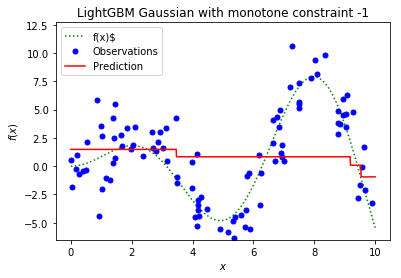

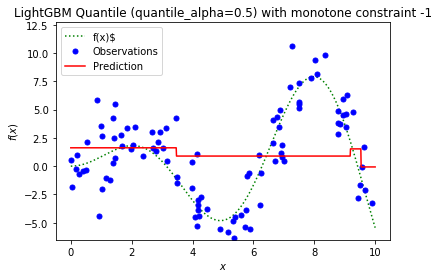

In [18]:
plot_prediction_quantile(xx, f(xx), r'f(x)$', X, y, y_pred_lgb, [min(y)-0.2*min(y), max(y)+0.2*max(y)], "LightGBM Gaussian with monotone constraint -1")
plot_prediction_quantile(xx, f(xx), r'f(x)$', X, y, y_middle_lgb, [min(y)-0.2*min(y), max(y)+0.2*max(y)], "LightGBM Quantile (quantile_alpha=0.5) with monotone constraint -1")

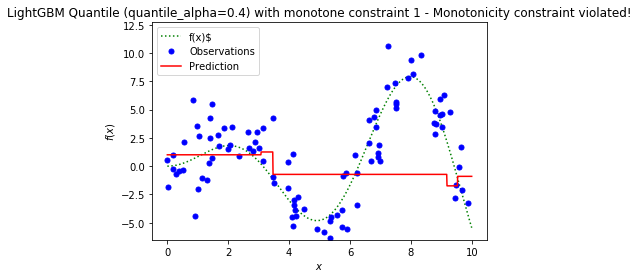

In [19]:
lgb_no_monotonicity = LGBMRegressor(objective='quantile', alpha=0.4, **lgb_params)
lgb_no_monotonicity .fit(X, y)
y_no_monotonicity_lgb = lgb_no_monotonicity.predict(xx)

plot_prediction_quantile(xx, f(xx), r'f(x)$', X, y, y_no_monotonicity_lgb, [min(y)-0.2*min(y), max(y)+0.2*max(y)], "LightGBM Quantile (quantile_alpha=0.4) with monotone constraint 1 - Monotonicity constraint violated!")